In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/test/surprise/PublicTest_78686873.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_58522921.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_83796714.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_84428313.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_87978901.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_90978621.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_27580582.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_15760011.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_49739228.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_5351857.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_56096676.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_71692098.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_64532931.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_17886908.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_21410542.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_68745885.jpg
/kaggle/input/fer2013/test/surpr

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Convolution2D, Dense, MaxPooling2D, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model

2024-06-23 11:20:31.943427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 11:20:31.943534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 11:20:32.242710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [4]:
img_width, img_height = 48, 48
epochs = 10
batch_size = 64
num_of_classes = 7

# Image augmentation

In [5]:
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)

In [6]:
train_ds = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_ds = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_ds = data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Plotting an augmented image

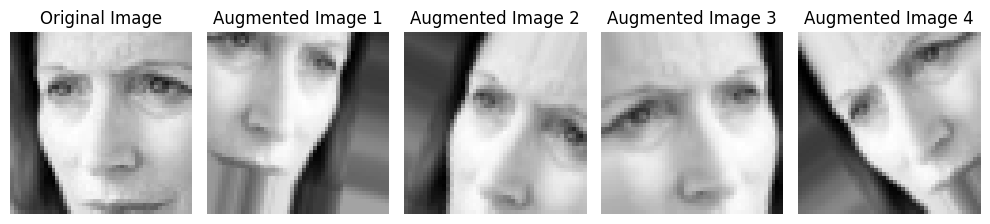

In [7]:
# Path to your specific image
image_path = '/kaggle/input/fer2013/train/fear/Training_10031494.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
model = Sequential()

model.add(Convolution2D(32, input_shape=(img_width, img_height, 1), kernel_initializer='glorot_uniform', kernel_size=(3,3), padding='same', activation='relu'))

model.add(Convolution2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Convolution2D(128, kernel_regularizer=regularizers.l2(0.01), kernel_size=(3,3), padding='same', activation='relu'))

model.add(Convolution2D(256, kernel_regularizer=regularizers.l2(0.01), kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Convolution2D(512, kernel_regularizer=regularizers.l2(0.01), kernel_size=(3,3), padding='same', activation='relu'))

model.add(Convolution2D(512, kernel_regularizer=regularizers.l2(0.01), kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

#Output layer
model.add(Dense(num_of_classes, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

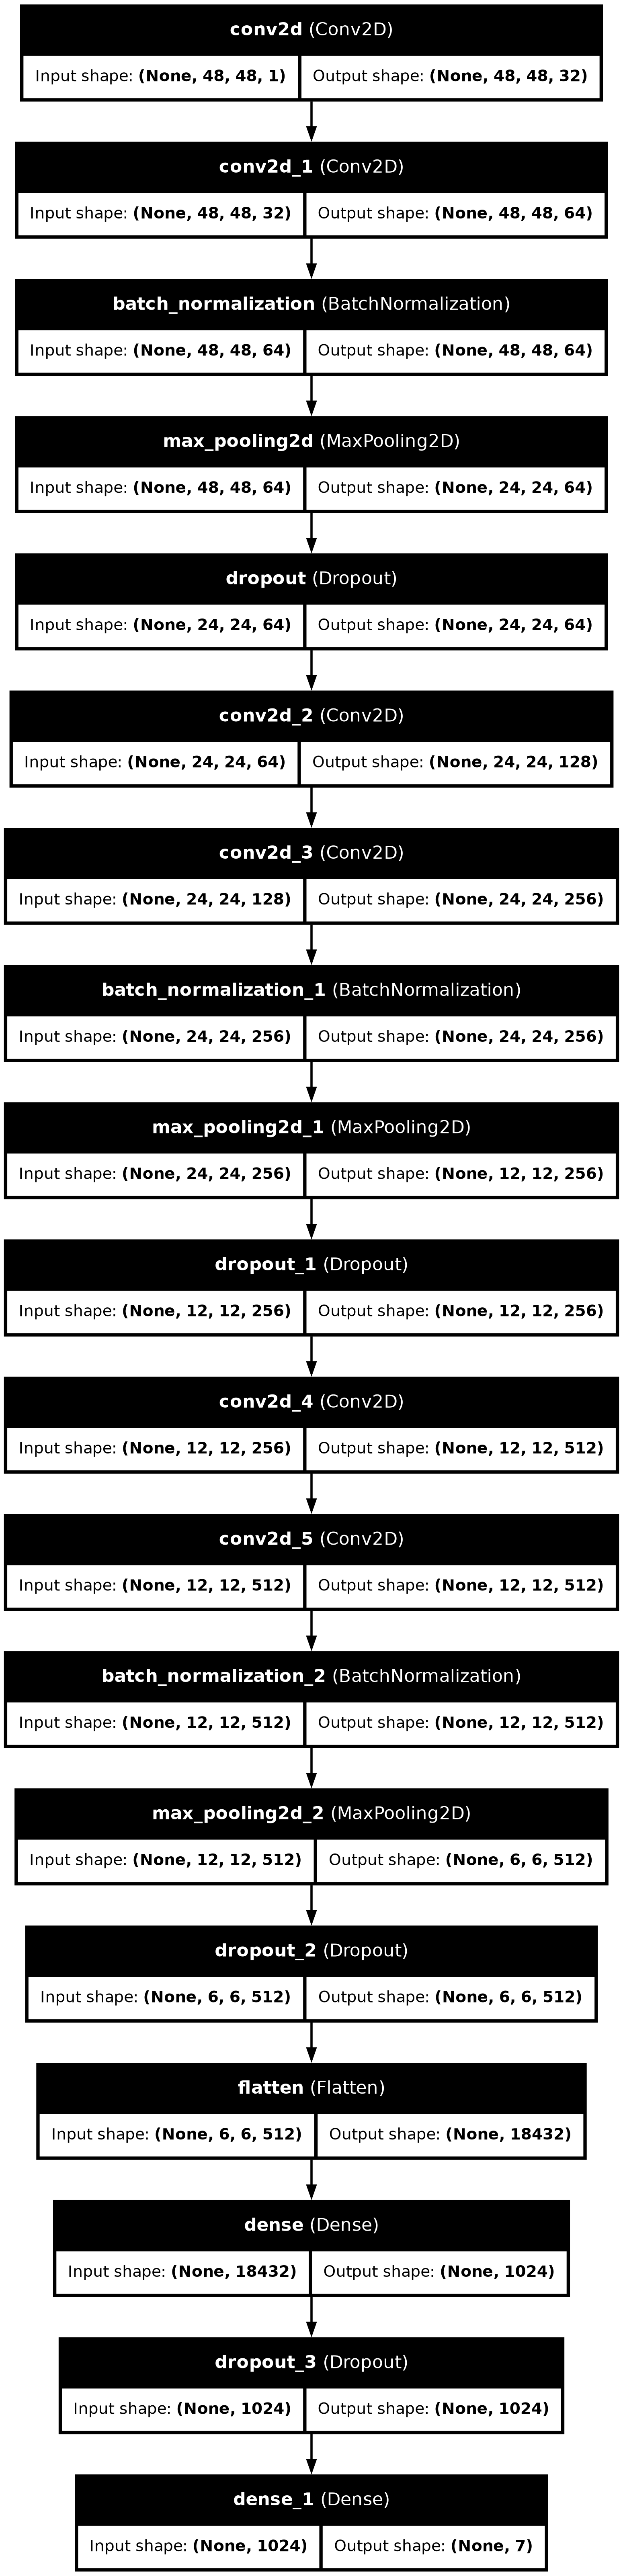

In [10]:
plot_model(model, to_file = '/kaggle/working/CNN-with-img-augmentation-Architecture.png',
           show_shapes=True, show_layer_names=True)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks

In [12]:
# File path for the model checkpoint
cnn_path = '/kaggle/working/'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

In [13]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [14]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [15]:
print(callbacks)

[<keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7d2a3896e350>, <keras.src.callbacks.early_stopping.EarlyStopping object at 0x7d2a3896cbe0>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x7d2a3896c370>, <keras.src.callbacks.csv_logger.CSVLogger object at 0x7d2a3896e890>]


# Calculating steps per epoch

In [16]:
train_steps_per_epoch = train_ds.samples // train_ds.batch_size + 1
validation_steps_epoch = validation_ds.samples // validation_ds.batch_size + 1
test_steps_epoch = test_ds.samples // test_ds.batch_size + 1

In [17]:
train_steps_per_epoch

359

In [18]:
validation_steps_epoch

90

In [19]:
test_steps_epoch

113

# Model Training

In [20]:
history = model.fit(
    train_ds,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_ds,
    #validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/359 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.0977 - loss: 16.5795   

I0000 00:00:1719141709.091669      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719141709.113587      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


245/359 ━━━━━━━━━━━━━━━━━━━━ 49s 436ms/step - accuracy: 0.2111 - loss: 13.7489

W0000 00:00:1719141815.259447      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.2173 - loss: 13.3299

W0000 00:00:1719141857.696993      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 15.20718, saving model to /kaggle/working/Custom_CNN_augmented_model.keras


W0000 00:00:1719141894.442616      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 215s 521ms/step - accuracy: 0.2173 - loss: 13.3268 - val_accuracy: 0.1730 - val_loss: 15.2072 - learning_rate: 1.0000e-04
Epoch 2/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 15.20718 to 15.18753, saving model to /kaggle/working/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1730 - val_loss: 15.1875 - learning_rate: 1.0000e-04
Epoch 3/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2538 - loss: 10.1105
Epoch 3: val_loss improved from 15.18753 to 9.62336, saving model to /kaggle/working/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 61s 166ms/step - accuracy: 0.2538 - loss: 10.1068 - val_accuracy: 0.1986 - val_loss: 9.6234 - learning_rate: 1.0000e-04
Epoch 4/100

Epoch 4: val_loss did not improve from 9.62336
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2007 - val_loss: 9.6417 - learning_rate: 1.0000e-04
Epoch 5/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2524 - loss: 7.6290
Epoch 5: val_loss improved from 9.62336 to 6.51842, saving mode

In [21]:
model.save('Custom_CNN_augmented_model.keras')

# Plotting the performance metrics

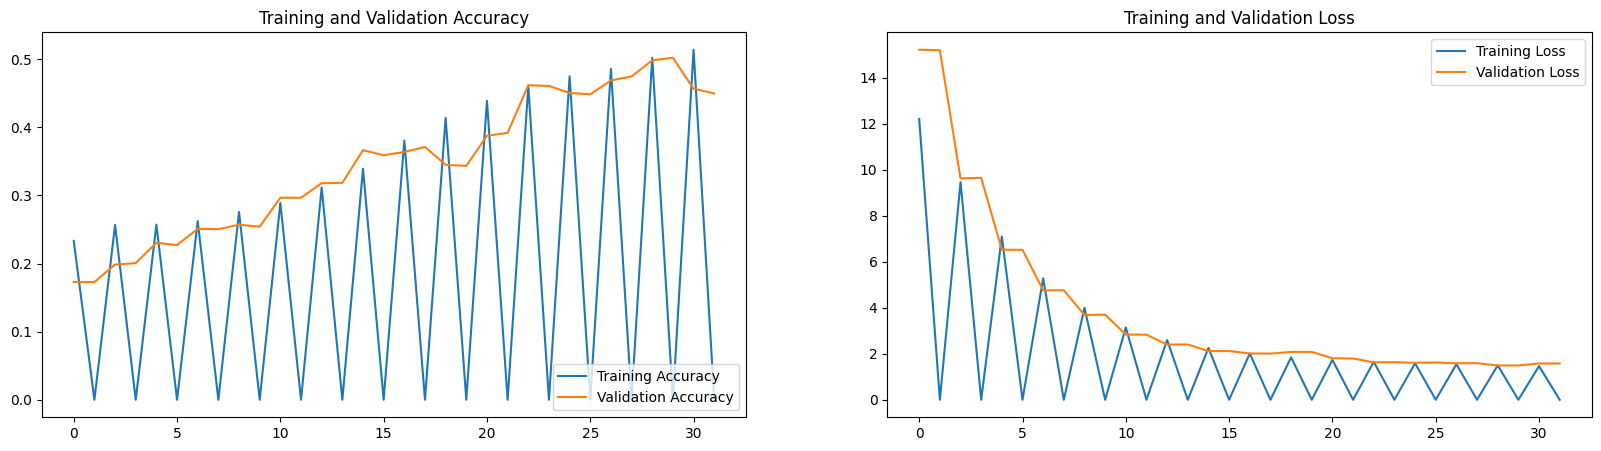

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show();

In [23]:
train_loss, train_acc = model.evaluate(train_ds)
test_loss, test_acc = model.evaluate(test_ds)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 133ms/step - accuracy: 0.5048 - loss: 1.4742


W0000 00:00:1719143027.087469      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 50s 443ms/step - accuracy: 0.4951 - loss: 1.4790
final train accuracy = 51.12 , validation accuracy = 49.94


W0000 00:00:1719143077.759220      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Plotting the confusion matrix

  3/113 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step   

W0000 00:00:1719143081.128209      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step


W0000 00:00:1719143096.268638      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


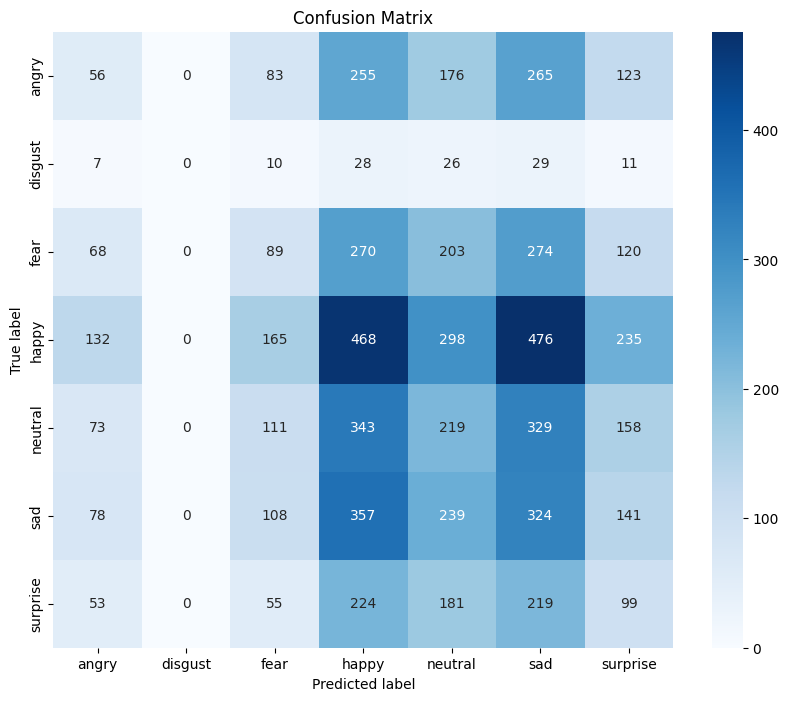

In [24]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_ds.classes
predicted_scores = model.predict(test_ds)
predicted_classes = np.argmax(predicted_scores, axis=1)
class_labels = list(test_ds.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Printing the classification report

In [25]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.06      0.08       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.09      0.11      1024
       happy       0.24      0.26      0.25      1774
     neutral       0.16      0.18      0.17      1233
         sad       0.17      0.26      0.20      1247
    surprise       0.11      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.17      7178

